In [1]:
#import spark.implicits._
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

bank_txt = spark.sparkContext.textFile("/data/examples/bank.csv")

bank_df = bank_txt.map(lambda s: re.sub(r'(?:^\"|\"$)', '', s))\
    .map(lambda s: re.split('\"?;\"?', s))\
    .filter(lambda s: s[0] != "age")\
    .map(lambda s: [int(s[0])] + s[1:4] + [int(s[5])]).toDF(['age', 'job', 'marital', 'education', 'balance'])
bank_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- balance: long (nullable = true)



In [2]:
bank_df.createOrReplaceTempView('bank_view')
bank_df.limit(5).toPandas()

,age,job,marital,education,balance
0,30,unemployed,married,primary,1787
1,33,services,married,secondary,4789
2,35,management,single,tertiary,1350
3,30,management,married,tertiary,1476
4,59,blue-collar,married,secondary,0


In [3]:
em_pdf = spark.sql('select education, marital, count(*) as count from bank_view group by education,marital')\
    .toPandas()
em_pdf.head(10)

,education,marital,count
0,unknown,married,117
1,unknown,single,46
2,unknown,divorced,24
3,primary,single,73
4,tertiary,single,468
5,secondary,divorced,270
6,primary,married,526
7,tertiary,divorced,155
8,primary,divorced,79
9,secondary,married,1427


In [4]:
pdf = em_pdf.pivot(index='education', columns='marital', values='count')
pdf

marital,divorced,married,single
education,,,
primary,79,526,73
secondary,270,1427,609
tertiary,155,727,468
unknown,24,117,46


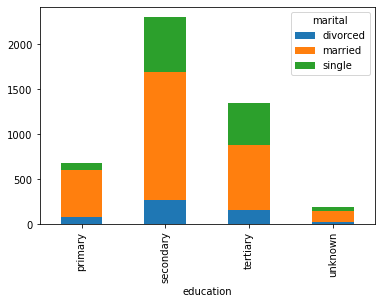

In [5]:
pdf.plot(kind='bar', stacked=True)
plt.show()

In [6]:
df = spark.read.csv("/data/examples/bank.csv", header=True, sep=';', 
                      mode="DROPMALFORMED", inferSchema=True)
df.write.mode("overwrite").saveAsTable("default.bank");
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [7]:
pd.DataFrame(spark.catalog.listTables("default"))

,name,database,description,tableType,isTemporary
0,bank,default,None,MANAGED,False
1,bank_jobs,default,None,MANAGED,False
2,bank_orc,default,None,MANAGED,False
3,bank_view,None,None,TEMPORARY,True


In [8]:
bank_df = spark.read.table("bank")
bank_jobs = bank_df.groupBy("job").count()
bank_jobs.createOrReplaceTempView("bank_jobs")
jobs_pd = spark.sql("select * from bank_jobs order by count desc limit 10").toPandas()
jobs_pd.head()

,job,count
0,management,969
1,blue-collar,946
2,technician,768
3,admin.,478
4,services,417


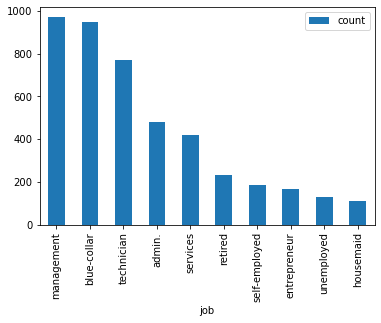

In [9]:
jobs_pd.plot(kind='bar', x='job', y='count', stacked=True)
plt.show()